# Detecting duplicate questions

### Info 
Date 11th of May 2017

Version 1.3: use of Google News words vectors

Version 1.2: use of XGBoost - differences in length as feature

Version 1: initial framework

Gilles Daquin

#### Difficulties: 

size of files 

spelling mistakes

no treatment of sematics 

some unicode characters not recognized by system 

laptop not setup for this type development

#### Main difficulties: 

a) extracting features to input in a Machine Learning algorithm

b) a lot of pre-processing on the data is necessary

# Synopsis

### Preparation
a) loading data

b) cleaning up the data

c) creation of dictionary

d) tokenization of questions

e) vectorization of questions

f) feature creation

### Feature creation (base)
a) Shared word percentage: SharedWord

b) lengths and difference of lengths:    

c) Cosine similarity:      CosineSim

e) other?...

### Feature extension (did not give good results)
a) X*X

b) X*Y

c) Log X

d) Sqrt(X)

### Feature validation
a) Assessment of feature strength with Random forest algorithm

### Training of model & test
a) train model (could be anything at this stage)

b) Test

### Prepare submission
a) save submission data


# Preparation

In [2]:
%matplotlib inline

#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re

import sklearn as sk
import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
import gensim

from nltk import bigrams
from nltk import trigrams

import xgboost


/home/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
verbose = False
nltk.download()
#prepare the stop words
STOP_WORDS = nltk.corpus.stopwords.words('english')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [48]:
#download the datasets
df_train = pd.read_csv("/home/gilles/Documents/NLP code/Data/train.csv")
df_tosubmit = pd.read_csv("/home/gilles/Documents/NLP code/Data/test.csv")

if (verbose):
    print(df_train.shape)
    print(df_test.shape)

### Reduce size of training set for development

Data set is more than 400K long, let's reduce it to speed up development time and testing of code


In [49]:
df_train_clean= df_train.sample(frac=1).reset_index(drop=True)
if (verbose):
     df_train_clean["is_duplicate"].sum()

In [50]:
if (verbose):
    df_train_clean.head()

In [51]:
#check for NANs
if (verbose):
    df_train_clean.isnull().sum()

## Clean up the NaNs

In [53]:
# we need to clean these NaNs
df_train_clean = df_train_clean.dropna()
df_tosubmit.fillna(" ", inplace = True)

In [56]:
if (verbose):
    print df_tosubmit.isnull().sum()
    print df_tosubmit.shape

In [57]:
verbose = False

In [58]:
if (verbose):
    print df_train_clean.isnull().sum()
    print df_train_clean.shape

### Before processing count number of words to try and differentiate the classes


In [59]:
def compute_length(sentence):
    "remove chars that are not letters or numbers, downcase"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', sentence).lower()
    length = len(sentence.split(" "))
    
    return length



In [60]:
df_train_clean["lengthQ1"]= df_train_clean["question1"].apply(compute_length)
df_train_clean["lengthQ2"]= df_train_clean["question2"].apply(compute_length)

In [61]:
df_tosubmit["lengthQ1"]= df_tosubmit["question1"].apply(compute_length)
df_tosubmit["lengthQ2"]= df_tosubmit["question2"].apply(compute_length)

In [62]:
df_tosubmit.head()

,test_id,question1,question2,lengthQ1,lengthQ2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,11,14
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,14,7
2,2,What but is the best way to send money from Ch...,What you send money to China?,14,6
3,3,Which food not emulsifiers?,What foods fibre?,4,3
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,4,6


### Stop words removal

In [64]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

In [65]:
df_train_clean["question1_nostopword"] = df_train_clean["question1"].apply(clean_sentence)
df_train_clean["question2_nostopword"] = df_train_clean["question2"].apply(clean_sentence)

In [66]:
df_tosubmit["question1_nostopword"] = df_tosubmit["question1"].apply(clean_sentence)
df_tosubmit["question2_nostopword"] = df_tosubmit["question2"].apply(clean_sentence)

In [80]:
df_train_clean["lengthQ1_nostopword"]= df_train_clean["question1_nostopword"].apply(compute_length)
df_train_clean["lengthQ2_nostopword"]= df_train_clean["question2_nostopword"].apply(compute_length)

In [81]:
df_tosubmit["lengthQ1_nostopword"]= df_tosubmit["question1_nostopword"].apply(compute_length)
df_tosubmit["lengthQ2_nostopword"]= df_tosubmit["question2_nostopword"].apply(compute_length)

## Look for common words

In [82]:
def commom_words(sentence1, sentence2):
    
    commonwords = [None] * len(sentence1)
    
    for i in range(len(sentence1)):
        sameWords = set.intersection(set(sentence1[i].split(" ")), set(sentence2[i].split(" ")))
        numberOfWords = len(sameWords)

        commonwords[i] = sameWords
    
    return commonwords

In [83]:
len(df_train_clean)

404288

In [84]:
#one of the indices doesn't load, reindex the data frame
df_train_clean = df_train_clean.reset_index(drop=True)

In [85]:
#check the words that in common
df_train_clean["Common"]= commom_words(df_train_clean["question1"],df_train_clean["question2"])
df_train_clean["Common_nostopword"]= commom_words(df_train_clean["question1_nostopword"],df_train_clean["question2_nostopword"])

In [87]:
df_tosubmit["Common"]= commom_words(df_tosubmit["question1"],df_tosubmit["question2"])
df_tosubmit["Common_nostopword"]= commom_words(df_tosubmit["question1_nostopword"],df_tosubmit["question2_nostopword"])

In [88]:
#compute the number of common words
df_train_clean["CommonLength"] = df_train_clean["Common"].apply(lambda x: len(x))
df_train_clean["CommonLength_nostopword"] = df_train_clean["Common_nostopword"].apply(lambda x: len(x))

In [89]:
df_tosubmit["CommonLength"] = df_tosubmit["Common"].apply(lambda x: len(x))
df_tosubmit["CommonLength_nostopword"] = df_tosubmit["Common_nostopword"].apply(lambda x: len(x))

In [90]:
#compute the average length of share words
def average_shared_length(length1, length2, shared):
    
    share_length = [None] * len(length1)
    
    for i in range(len(length1)):
        # print shared[i+1]
        if (float(length1[i]+length2[i])>0):
            share_length[i] = float(shared[i])/float(length1[i]+length2[i])
        else:
            share_length[i] = 0

    return share_length

In [91]:
df_train_clean["Shared"]= average_shared_length(df_train_clean["lengthQ1"],df_train_clean["lengthQ2"],
                                                df_train_clean["CommonLength"])

In [92]:
df_tosubmit["Shared"]= average_shared_length(df_tosubmit["lengthQ1"],df_tosubmit["lengthQ2"],
                                                df_tosubmit["CommonLength"])

In [93]:
df_train_clean["Shared_nostopword"]= average_shared_length(df_train_clean["lengthQ1_nostopword"],df_train_clean["lengthQ2_nostopword"],
                                                df_train_clean["CommonLength_nostopword"])

In [94]:
df_tosubmit["Shared_nostopword"]= average_shared_length(df_tosubmit["lengthQ1_nostopword"],df_tosubmit["lengthQ2_nostopword"],
                                                df_tosubmit["CommonLength_nostopword"])

In [95]:
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,Common,CommonLength,Shared,lengthQ1_nostopword,lengthQ2_nostopword,Common_nostopword,CommonLength_nostopword,Shared_nostopword
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,"{still, Kaif, is, Katrina, in}",5,0.185185,8,7,"{still, kaif, katrina}",3,0.200000
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,"{OLET, (Organic, Light-Emitting, Transistors)}",4,0.222222,7,5,"{lightemitting, olet, transistors, organic}",4,0.333333
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,"{is, Peepal, tree, the}",4,0.166667,5,6,"{peepal, tree}",2,0.181818


## Lemmatization

(recheck position in preparation)

In [96]:
#let's do some lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

df_train_clean["question1_lem"] = df_train_clean["question1_nostopword"].apply(lmtzr.lemmatize)
df_train_clean["question2_lem"] = df_train_clean["question2_nostopword"].apply(lmtzr.lemmatize)

In [97]:
df_tosubmit["question1_lem"] = df_tosubmit["question1_nostopword"].apply(lmtzr.lemmatize)
df_tosubmit["question2_lem"] = df_tosubmit["question2_nostopword"].apply(lmtzr.lemmatize)

In [98]:
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,Common,CommonLength,Shared,lengthQ1_nostopword,lengthQ2_nostopword,Common_nostopword,CommonLength_nostopword,Shared_nostopword,question1_lem,question2_lem
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,"{still, Kaif, is, Katrina, in}",5,0.185185,8,7,"{still, kaif, katrina}",3,0.200000,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,"{OLET, (Organic, Light-Emitting, Transistors)}",4,0.222222,7,5,"{lightemitting, olet, transistors, organic}",4,0.333333,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,"{is, Peepal, tree, the}",4,0.166667,5,6,"{peepal, tree}",2,0.181818,significance peepal tree indian culture,possible peepal tree releases oxygen time


## Stemming

In [99]:
from nltk.stem.porter import PorterStemmer

def stem_tokens(tokens):
 
    porter_stemmer = PorterStemmer()
    #print tokens
    wordList = re.sub("[^\w]", " ",  tokens).split()
    stemmed = []
    for item in wordList:
        stemmed.append(porter_stemmer.stem(item))
    print stemmed    
    return stemmed



In [102]:
execute = 0
#a bit too long
if (execute==1):
    df_train_clean["question1_stem"] = df_train_clean["question1_lem"].apply(stem_tokens)
    df_train_clean["question2_stem"] = df_train_clean["question2_lem"].apply(stem_tokens)
    df_tosubmit["question1_stem"] = df_tosubmit["question1_lem"].apply(stem_tokens)
    df_tosubmit["question2_stem"] = df_tosubmit["question2_lem"].apply(stem_tokens)
    

## Compute lengths post-process

In [104]:
df_train_clean["lengthPP_Q1"]= df_train_clean["question1_lem"].apply(compute_length)
df_train_clean["lengthPP_Q2"]= df_train_clean["question2_lem"].apply(compute_length)

In [105]:
df_train_clean["SharedPP"]= average_shared_length(df_train_clean["lengthPP_Q1"],df_train_clean["lengthPP_Q2"],
                                                df_train_clean["CommonLength"])

In [106]:
df_tosubmit["lengthPP_Q1"]= df_tosubmit["question1_lem"].apply(compute_length)
df_tosubmit["lengthPP_Q2"]= df_tosubmit["question2_lem"].apply(compute_length)

In [107]:
df_tosubmit["SharedPP"]= average_shared_length(df_tosubmit["lengthPP_Q1"],df_tosubmit["lengthPP_Q2"],
                                                df_tosubmit["CommonLength"])

In [108]:
#sanity check
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,...,lengthQ1_nostopword,lengthQ2_nostopword,Common_nostopword,CommonLength_nostopword,Shared_nostopword,question1_lem,question2_lem,lengthPP_Q1,lengthPP_Q2,SharedPP
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,...,8,7,"{still, kaif, katrina}",3,0.200000,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,8,7,0.333333
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,...,7,5,"{lightemitting, olet, transistors, organic}",4,0.333333,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,7,5,0.333333
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,...,5,6,"{peepal, tree}",2,0.181818,significance peepal tree indian culture,possible peepal tree releases oxygen time,5,6,0.363636


## Build length differences features

In [109]:
df_train_clean["lenth_diff"] = np.abs(df_train_clean["lengthQ2"]-df_train_clean["lengthQ1"])
df_train_clean["lengthPP_diff"]= np.abs(df_train_clean["lengthPP_Q1"]-df_train_clean["lengthPP_Q2"])
df_train_clean["lenth_diff_nostopword"] = np.abs(df_train_clean["lengthQ2_nostopword"]-df_train_clean["lengthQ1_nostopword"])

In [110]:
df_tosubmit["lenth_diff"] = np.abs(df_tosubmit["lengthQ2"]-df_tosubmit["lengthQ1"])
df_tosubmit["lengthPP_diff"]= np.abs(df_tosubmit["lengthPP_Q1"]-df_tosubmit["lengthPP_Q2"])
df_tosubmit["lenth_diff_nostopword"] = np.abs(df_tosubmit["lengthQ2_nostopword"]-df_tosubmit["lengthQ1_nostopword"])

In [111]:
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,...,CommonLength_nostopword,Shared_nostopword,question1_lem,question2_lem,lengthPP_Q1,lengthPP_Q2,SharedPP,lenth_diff,lengthPP_diff,lenth_diff_nostopword
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,...,3,0.200000,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,8,7,0.333333,3,1,1
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,...,4,0.333333,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,7,5,0.333333,4,2,2
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,...,2,0.181818,significance peepal tree indian culture,possible peepal tree releases oxygen time,5,6,0.363636,2,1,1


## Use Google's word 2 vec Model (currently 30h for similarity computation!...)

### switch back to word2vec with the questions corpus


In [112]:
from gensim.models import KeyedVectors

GoogleModel = 0

if(GoogleModel):
    # Load Google's pre-trained Word2Vec model.
    model = KeyedVectors.load_word2vec_format('./Data/GoogleNews-vectors-negative300.bin', binary=True)
    min_count = 2
    size = 300
    window = 4

In [113]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1_nostopword', 'question2_nostopword']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus


In [114]:
from gensim.models import Word2Vec

if(GoogleModel == 0):
    corpus = build_corpus(df_train_clean)
    min_count = 2
    size = 100
    window = 4
    model = Word2Vec(corpus, min_count=min_count, size=size, window=window)

In [115]:
model.similarity("plane","train")

0.38970312785645772

### compute cosine similarity between two questions

for each questions, we will compute the vector for each word then we will sum all the vectors and will take the average value as the length of each questions maye be different and will compare the results of one question against the other to determine the cosine similarity

In [116]:
#This function takes too much time other the full training data (+40 hours)
def avg_feature_vector(words, model, num_features, index2word_set):
        #function to average all words vectors in a given paragraph
        featureVec = np.zeros((num_features,), dtype="float32")
        nwords = 0
        #print words
        #wordList = re.sub("[^\w]", " ",  words[1]).split()
        wordList = words.split()
        #list containing names of words in the vocabulary
        for word in wordList:
            if word in index2word_set:
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])
                
        if(nwords>0):
            featureVec = np.divide(featureVec, nwords)
        return featureVec

In [123]:
from scipy import spatial

#Becareful
#word2vec uses model.wv.index2word
#Keyedvector uses model.index2word

def computeCosine(df1,df2):
    cosineSimilarity = [None] * len(df1)
    
    for i in range(len(df1)):
        if((i%30000) == 1): print i-1 #show how we are progression
        sentence_1_avg_vector = avg_feature_vector(df1[i], model, size, model.wv.index2word)
        sentence_2_avg_vector = avg_feature_vector(df2[i], model, size, model.wv.index2word)
        cosineSimilarity[i] =  1 - spatial.distance.cosine(sentence_1_avg_vector,sentence_2_avg_vector)
    return cosineSimilarity

In [118]:
#useful to re-initialize while developping
df_train_clean["cosine"] = 0
df_tosubmit["cosine"] = 0

In [119]:
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,...,Shared_nostopword,question1_lem,question2_lem,lengthPP_Q1,lengthPP_Q2,SharedPP,lenth_diff,lengthPP_diff,lenth_diff_nostopword,cosine
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,...,0.200000,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,8,7,0.333333,3,1,1,0
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,...,0.333333,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,7,5,0.333333,4,2,2,0
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,...,0.181818,significance peepal tree indian culture,possible peepal tree releases oxygen time,5,6,0.363636,2,1,1,0


In [120]:
#test
#a = model.most_similar_cosmul(positive=['difference', 'yield','curve','par'])

In [121]:
#distance = model.wmdistance("difference yield curve par curve", "certification prefer itil currently certified")

In [122]:
#for i in range(len(df_train_clean)):
#df_train_clean["cosine"][:3] = computeCosine(df_train_clean["question1_nostopword"][:3],df_train_clean["question2_nostopword"][:3])
df_train_clean["cosine"]= computeCosine(df_train_clean["question1_nostopword"],df_train_clean["question2_nostopword"])

0


/home/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/spatial/distance.py:326: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


50000
100000
150000
200000
250000
300000
350000
400000


In [124]:
df_tosubmit["cosine"]= computeCosine(df_tosubmit["question1_nostopword"],df_tosubmit["question2_nostopword"])

0
30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000
1050000
1080000
1110000
1140000
1170000
1200000
1230000
1260000
1290000
1320000
1350000
1380000
1410000
1440000
1470000
1500000
1530000
1560000
1590000
1620000
1650000
1680000
1710000
1740000
1770000
1800000
1830000
1860000
1890000
1920000
1950000
1980000
2010000
2040000
2070000
2100000
2130000
2160000
2190000
2220000
2250000
2280000
2310000
2340000


In [125]:
df_train_clean[df_train_clean["cosine"].isnull()].head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,...,Shared_nostopword,question1_lem,question2_lem,lengthPP_Q1,lengthPP_Q2,SharedPP,lenth_diff,lengthPP_diff,lenth_diff_nostopword,cosine
710,55507,97850,97851,What is clax?,What is #?,0,3,3,clax,,...,0.0,clax,,1,1,1.0,0,0,0,NaN
1011,17245,32795,32796,"If [math](mn+3)^2=-|m+n+2|[/math], what is [ma...",What are some gentle music?,0,5,5,mathmn32mn2math mathm2n2mn2math,gentle music,...,0.0,mathmn32mn2math mathm2n2mn2math,gentle music,2,2,0.0,0,0,0,NaN
1376,185028,282557,282558,What is dicyclohexylcarbodiimide?,How do I keep updating my service with Verizon?,0,3,9,dicyclohexylcarbodiimide,keep updating service verizon,...,0.0,dicyclohexylcarbodiimide,keep updating service verizon,1,4,0.0,6,3,3,NaN


### check we did not have any aberation for cosinus similarity (strange characters, etc...)

In [131]:
df_train_clean["cosine"].fillna(0, inplace=True)

In [132]:
df_tosubmit["cosine"].fillna(0, inplace=True)

In [133]:
df_tosubmit["cosine"].isnull().sum()

0

In [134]:
df_train_clean.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,question1_nostopword,question2_nostopword,...,Shared_nostopword,question1_lem,question2_lem,lengthPP_Q1,lengthPP_Q2,SharedPP,lenth_diff,lengthPP_diff,lenth_diff_nostopword,cosine
0,230037,10403,339472,How is Katrina Kaif still surviving in the ind...,Why is Katrina Kaif still in India when she al...,0,12,15,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,...,0.200000,katrina kaif still surviving industry without ...,katrina kaif still india already realizes tale...,8,7,0.333333,3,1,1,0.598396
1,347840,476336,476337,What is stopping OLET (Organic Light-Emitting ...,Has OLET (Organic Light-Emitting Transistors) ...,1,11,7,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,...,0.333333,stopping olet organic lightemitting transistor...,olet organic lightemitting transistors abandoned,7,5,0.333333,4,2,2,0.912492
2,391501,524083,183040,What is the significance of the Peepal tree in...,How is it possible that the Peepal tree releas...,0,11,13,significance peepal tree indian culture,possible peepal tree releases oxygen time,...,0.181818,significance peepal tree indian culture,possible peepal tree releases oxygen time,5,6,0.363636,2,1,1,0.070620


In [135]:
print len(df_train_clean)
print len(df_tosubmit)

404288
2345796


### check use of TF-IDF

time allowing probably with not have too much used due too much sparsity

In [70]:
#Needs to check in conjunction with word2vec
#tfidf = models.TfidfModel(corpus)

# Apply Model

### Scale the data

In [136]:
df_train_clean.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'lengthQ1', u'lengthQ2', u'question1_nostopword',
       u'question2_nostopword', u'Common', u'CommonLength', u'Shared',
       u'lengthQ1_nostopword', u'lengthQ2_nostopword', u'Common_nostopword',
       u'CommonLength_nostopword', u'Shared_nostopword', u'question1_lem',
       u'question2_lem', u'lengthPP_Q1', u'lengthPP_Q2', u'SharedPP',
       u'lenth_diff', u'lengthPP_diff', u'lenth_diff_nostopword', u'cosine'],
      dtype='object')

In [137]:
df_tosubmit.columns

Index([u'test_id', u'question1', u'question2', u'lengthQ1', u'lengthQ2',
       u'question1_nostopword', u'question2_nostopword', u'Common',
       u'CommonLength', u'Shared', u'lengthQ1_nostopword',
       u'lengthQ2_nostopword', u'Common_nostopword',
       u'CommonLength_nostopword', u'Shared_nostopword', u'question1_lem',
       u'question2_lem', u'lengthPP_Q1', u'lengthPP_Q2', u'SharedPP',
       u'lenth_diff', u'lengthPP_diff', u'lenth_diff_nostopword', u'cosine'],
      dtype='object')

In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


list_of_Numeric_fields= ['CommonLength', 
                         'CommonLength_nostopword',
                         'lengthPP_Q1', 
                         'lengthPP_Q2', 
                         'lenth_diff', 
                         'lengthPP_diff', 
                         'lenth_diff_nostopword', 
                         'Shared',
                         'SharedPP',
                         'Shared_nostopword',
                         'cosine']

list_of_Numeric_fields_save= ['lengthQ1', 'lengthQ2',
                         'CommonLength','Shared', 
                         'cosine', 'lengthPP_Q1', 
                         'lengthPP_Q2','SharedPP',
                         'lenth_diff','lengthPP_diff']



In [196]:
df_train_clean[list_of_Numeric_fields].head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
0,5,3,8,7,3,1,1,0.185185,0.333333,0.200000,0.598396
1,4,4,7,5,4,2,2,0.222222,0.333333,0.333333,0.912492
2,4,2,5,6,2,1,1,0.166667,0.363636,0.181818,0.070620
3,1,0,7,6,4,1,1,0.035714,0.076923,0.000000,0.513880
4,3,3,8,5,9,3,3,0.130435,0.230769,0.230769,0.758771


In [197]:
df_test = df_train_clean.copy()
dt_submit = df_tosubmit.copy()

In [198]:
df_train_clean[list_of_Numeric_fields].head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
0,5,3,8,7,3,1,1,0.185185,0.333333,0.200000,0.598396
1,4,4,7,5,4,2,2,0.222222,0.333333,0.333333,0.912492
2,4,2,5,6,2,1,1,0.166667,0.363636,0.181818,0.070620
3,1,0,7,6,4,1,1,0.035714,0.076923,0.000000,0.513880
4,3,3,8,5,9,3,3,0.130435,0.230769,0.230769,0.758771


In [199]:
def scaler(column):
    scaled_x = [0.0] * len(column)
    
    minimum = column.min()
    maximum = column.max()
        
    difference = maximum - minimum
    
    for i in range(len(column)):
        scaled_x[i] = (column[i] - minimum) / float(difference)   
    return scaled_x

In [200]:
for i in list_of_Numeric_fields:
        df_test[i] = scaler(df_test[i])
        dt_submit[i]= scaler(dt_submit[i])

In [201]:
df_test[list_of_Numeric_fields].head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
0,0.119048,0.125000,0.132075,0.056604,0.013453,0.009901,0.009901,0.370370,0.083333,0.400000,0.709992
1,0.095238,0.166667,0.113208,0.037736,0.017937,0.019802,0.019802,0.444444,0.083333,0.666667,0.936808
2,0.095238,0.083333,0.075472,0.047170,0.008969,0.009901,0.009901,0.333333,0.090909,0.363636,0.328871
3,0.023810,0.000000,0.113208,0.047170,0.017937,0.009901,0.009901,0.071429,0.019231,0.000000,0.648960
4,0.071429,0.125000,0.132075,0.037736,0.040359,0.029703,0.029703,0.260870,0.057692,0.461538,0.825802


In [202]:
dt_submit[list_of_Numeric_fields].head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
0,0.045455,0.111111,0.047170,0.084112,0.013636,0.039604,0.039604,0.160000,0.035714,0.375000,0.827131
1,0.090909,0.148148,0.056604,0.037383,0.031818,0.019802,0.019802,0.380952,0.095238,0.666667,0.882305
2,0.090909,0.111111,0.047170,0.018692,0.036364,0.029703,0.029703,0.400000,0.126984,0.666667,0.893680
3,0.000000,0.000000,0.009434,0.009346,0.004545,0.000000,0.000000,0.000000,0.000000,0.000000,0.783066
4,0.068182,0.074074,0.018868,0.009346,0.009091,0.009901,0.009901,0.600000,0.171429,0.800000,1.000000


In [203]:
#scale only the numerical features of our dataset
#to retry
#scaler.fit_transform(df_train_clean[list_of_Numeric_fields])

### Prepare the entry data

In [204]:
Y = df_test.is_duplicate

In [250]:
from sklearn.cross_validation import train_test_split

#vary test size, for submission, train on full sample
TEST_SIZE = 0.20

#separate our data between training and test data
X_train, X_test, y_train, y_test = train_test_split(df_test[list_of_Numeric_fields], Y, test_size = TEST_SIZE)

In [206]:
X_train.head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
231027,0.023810,0.000000,0.075472,0.047170,0.000000,0.009901,0.009901,0.111111,0.022727,0.000000,0.429322
7197,0.047619,0.083333,0.075472,0.094340,0.022422,0.059406,0.059406,0.137931,0.031250,0.250000,0.855901
275231,0.071429,0.041667,0.075472,0.037736,0.004484,0.000000,0.000000,0.315789,0.075000,0.200000,0.684602
294708,0.071429,0.041667,0.075472,0.047170,0.008969,0.009901,0.009901,0.300000,0.068182,0.181818,0.771652
221249,0.119048,0.166667,0.075472,0.084906,0.058296,0.049505,0.049505,0.322581,0.083333,0.533333,0.947739


### Run the models

In [207]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# (a)select a classifier: here random forest
forest = RandomForestClassifier(n_estimators = 60)

adab = AdaBoostClassifier(n_estimators = 60)


In [208]:
# (b)train the model
forestC = forest.fit(X_train,y_train.values.ravel())
adabC = adab.fit(X_train,y_train.values.ravel())

In [209]:
## Try SVM
#Timing of SVM for half data: 13:30 -> 13:40
excute_SVM = 0
from sklearn import svm
if(excute_SVM):
    svmC = svm.SVC()
    svmC.fit(X_train,y_train)

In [210]:
# fit XGB model 
modelXGB = xgboost.XGBClassifier(base_score=0.5)
modelXGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Get the scores

In [211]:
#score with fixed decision
1-y_test.sum()/float(len(y_test))

0.63005515842588244

In [212]:
if(excute_SVM):
    svmC.score(X_test,y_test.values.ravel())

In [213]:
#score with random forest
forestC.score(X_test,y_test.values.ravel())

0.71866729327957657

In [214]:
#score with Adaboost
adabC.score(X_test,y_test.values.ravel())

0.72535803507383312

In [215]:
# make predictions for test data
y_pred = modelXGB.predict(X_test)
predictions = [round(value) for value in y_pred]

In [216]:
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
print accuracy

0.733978085038


In [217]:
#print(model)

# Use regressors

(kaggle code)

In [218]:
from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

In [219]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [220]:
from sklearn.svm import SVR
#computation time for half data 30 minutes
if(excute_SVM):
    svr = SVR()
    svr.fit(X_train,y_train)

In [221]:
y_rfr_predicted = rfr.predict(X_test)

if(excute_SVM):
    y_svr_predicted = svr.predict(X_test)
    
y_xgb_predicted = modelXGB.predict_proba(X_test)    

In [222]:
logloss_rfr = calculate_logloss(y_test, y_rfr_predicted)
logloss_xgb = calculate_logloss(y_test, y_xgb_predicted)

if(excute_SVM):
    logloss_svr = calculate_logloss(y_test, y_svr_predicted)


print ("The calculated log loss value on the test set using RFR is = %f" %logloss_rfr)

#SVM regressor takes very long for so so results
if(excute_SVM):
    print ("The calculated log loss value on the test set using SVR is = %f" %logloss_svr)

print ("The calculated log loss value on the test set using XGB is = %f" %logloss_xgb)

The calculated log loss value on the test set using RFR is = 1.127208
The calculated log loss value on the test set using XGB is = 0.469804


## Check what features are important

In [223]:
#pick all the features
features = pd.DataFrame(forest.feature_importances_)


In [224]:
#rank the features by order of importance for classification
#this will be useful 
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [225]:
# Print the feature ranking (comes from trial and error looking at the graph below)
Max_number_of_indices = len(list_of_Numeric_fields)

print("Feature ranking:")

for f in range(Max_number_of_indices):
    print("%d. feature %d (%f) percentage %f" % (f + 1, indices[f], importances[indices[f]] , 
                                                 importances[indices[f]]/importances[indices[0]]))


Feature ranking:
1. feature 10 (0.445519) percentage 1.000000
2. feature 7 (0.167739) percentage 0.376503
3. feature 9 (0.114126) percentage 0.256165
4. feature 4 (0.068454) percentage 0.153650
5. feature 8 (0.064658) percentage 0.145130
6. feature 0 (0.033623) percentage 0.075470
7. feature 1 (0.030465) percentage 0.068381
8. feature 3 (0.023957) percentage 0.053773
9. feature 2 (0.023802) percentage 0.053425
10. feature 6 (0.014233) percentage 0.031947
11. feature 5 (0.013424) percentage 0.030132


In [226]:
#top_indices really means here "most important features selected" - first show all the features
Max_number_of_indices = len(importances)

top_indices = indices[:Max_number_of_indices]


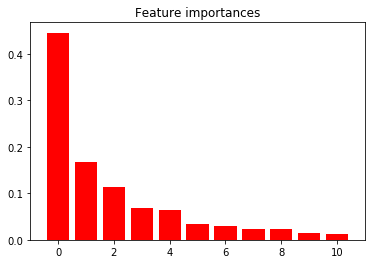

In [227]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(Max_number_of_indices), importances[top_indices], color="r", align="center")
plt.xlim([-1, Max_number_of_indices])
plt.ion()
plt.show()

In [228]:
X_train[top_indices].head()

,cosine,Shared,Shared_nostopword,lenth_diff,SharedPP,CommonLength,CommonLength_nostopword,lengthPP_Q2,lengthPP_Q1,lenth_diff_nostopword,lengthPP_diff
231027,0.429322,0.111111,0.000000,0.000000,0.022727,0.023810,0.000000,0.047170,0.075472,0.009901,0.009901
7197,0.855901,0.137931,0.250000,0.022422,0.031250,0.047619,0.083333,0.094340,0.075472,0.059406,0.059406
275231,0.684602,0.315789,0.200000,0.004484,0.075000,0.071429,0.041667,0.037736,0.075472,0.000000,0.000000
294708,0.771652,0.300000,0.181818,0.008969,0.068182,0.071429,0.041667,0.047170,0.075472,0.009901,0.009901
221249,0.947739,0.322581,0.533333,0.058296,0.083333,0.119048,0.166667,0.084906,0.075472,0.049505,0.049505


not surprisingly, the cosine similarity is the most significative features in the classification

# Results part

Train final model on full training data

Predict questions similarity

Save answers for submission

In [251]:
X_train.head()

,CommonLength,CommonLength_nostopword,lengthPP_Q1,lengthPP_Q2,lenth_diff,lengthPP_diff,lenth_diff_nostopword,Shared,SharedPP,Shared_nostopword,cosine
311876,0.095238,0.083333,0.037736,0.009434,0.013453,0.009901,0.009901,0.615385,0.200000,0.800000,1.000000
136761,0.119048,0.125000,0.075472,0.028302,0.004484,0.009901,0.009901,0.588235,0.138889,0.666667,0.953555
17054,0.095238,0.083333,0.037736,0.018868,0.000000,0.000000,0.000000,0.500000,0.166667,0.666667,0.841392
128629,0.047619,0.083333,0.094340,0.037736,0.004484,0.009901,0.009901,0.190476,0.045455,0.363636,0.821344
58256,0.000000,0.083333,0.150943,0.037736,0.049327,0.039604,0.039604,0.000000,0.000000,0.285714,0.883968


## Train final model on full training data

In [252]:
# fit XGB model 
modelXGB = xgboost.XGBClassifier(base_score=0.5)
modelXGB.fit(df_test[list_of_Numeric_fields], Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Predict questions similarity

In [253]:
y_xgb_predicted = modelXGB.predict_proba(dt_submit[list_of_Numeric_fields])    

In [264]:
result_list = [res[0] for res in y_xgb_predicted]

## Save answers for submission

In [265]:
submission = pd.DataFrame()

submission['test_id'] = dt_submit['test_id']
submission['is_duplicate'] = result_list 

submission.head()

,test_id,is_duplicate
0,0,0.891770
1,1,0.352745
2,2,0.379189
3,3,0.998068
4,4,0.603235


In [266]:
submission.to_csv('subsmission.csv', index=False)